In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import itertools
import math
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Binarizer, MaxAbsScaler, Normalizer, PowerTransformer, QuantileTransformer
from sklearn import preprocessing, linear_model
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from skopt import gp_minimize, dummy_minimize
from skopt.plots import plot_convergence
from matplotlib.pyplot import figure
from PIL import Image
from IPython.display import display, Image
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, mean_squared_error, max_error, mean_absolute_error, roc_curve, r2_score
from shapely.geometry.polygon import Polygon
from scipy.spatial import ConvexHull
from decimal import Decimal

## Carregamento e Limpeza dos Dados

 Vamos começar carregando todos os dados, com seus respectivos nomes de variáveis definidos originalmente no repositório UCI.
 
 Perceba que os dados estão em escalas diferentes. Além disto, a variável Sex é categórica e contém strings em suas linhas. Vamos precisar tratar isto mais a frente para que os modelos de machine learning trabalhem com números e não com letras.

 Links:
 
 - https://pandas.pydata.org/

In [2]:
warnings.filterwarnings("ignore")

dados_originais = pd.read_csv("abalone.csv", header = None,
                              names = ["Sex", "Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight", "Rings"])

dados = dados_originais.copy()
dados.head(10)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


 Temos um total de 4177 registros:

In [3]:
len(dados)

4177

 E nenhum deles é duplicado.

In [4]:
dados_originais.duplicated().any()

False

 Informações acerca de pesos e comprimentos são continuos, logo seus tipos de dados são do tipo float. Além disto Rings somada com 1.5 representa idade, porém a variável em si é inteira(segundo informações originais no UCI). Por sorte, todos os tipos dos dados foram mantidos.

In [5]:
dados.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
Rings               int64
dtype: object

 Nos dados, os abalones estão divididos em três generos: masculino(M), femenino(F) e infantil(I). Converteremos ambos os generos em 0, 1 e 2 respectivamente.

In [6]:
numerico = {"M": 0, "F": 1, "I": 2}
dados.Sex.replace(numerico, inplace = True)
dados_originais.Sex.replace(numerico, inplace = True)
dados.head(10)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,2,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,1,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,1,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,0,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,1,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


 Note que os dados em relação ao genero dos abalones estão bem equilibrados. Não temos um genero com uma quantidade muito maior que outro neste conjunto de dados. Mas balancear uma variável preditiva não é o importante, e sim a variável preditora. Segundo o UCI, podemos usar tanto regressão, quanto classificação para este problema. Iremos optar pela classificação e portanto precisamos equilibar a variável target Rings. Iremos fazer tal balanceamento mais a frente.

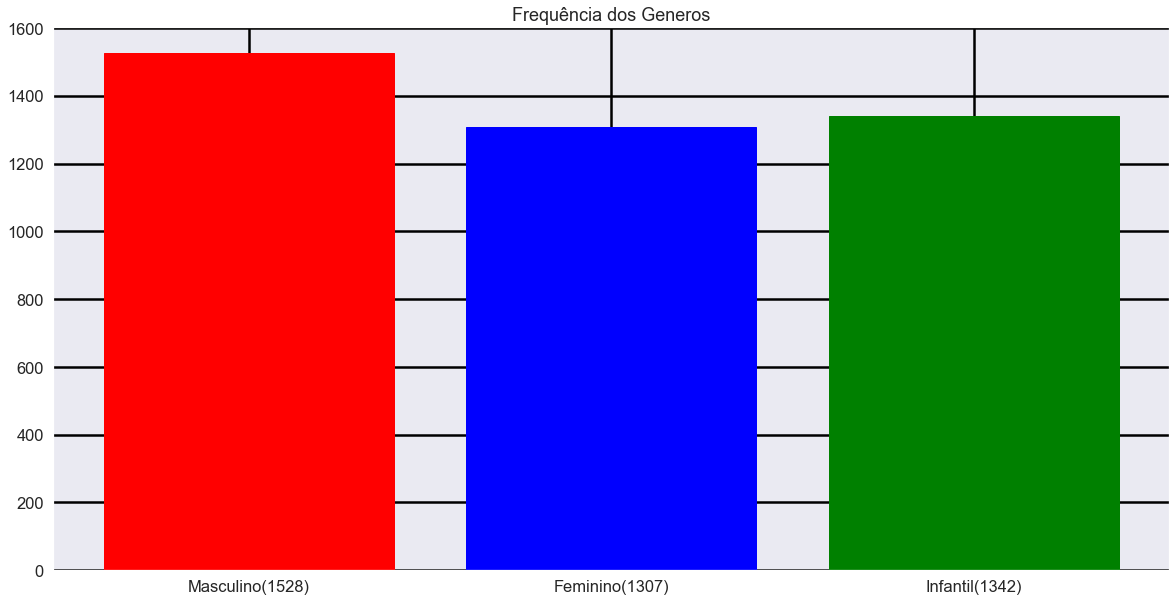

In [7]:
def barra(d):
    sns.set(font_scale = 1.5)
    figure(figsize = (20,10))
    bar = plt.bar(['Masculino(1528)', 'Feminino(1307)', 'Infantil(1342)'], d.groupby("Sex").Length.count())
    bar[0].set_color("red")
    bar[1].set_color("blue")
    bar[2].set_color("green")
    plt.grid(color = 'black', linestyle = '-', linewidth = 2.5)
    plt.title("Frequência dos Generos")
    plt.show()
    sns.set()

barra(d = dados)

### Estatísticas dos Dados

 Vamos analisar as principais informações estatísticas dos dados.
 
 Veja quem na variável Sex, temos uma média proxima a 1 e desvio padrão também proximo a 1, indicando que os dados se concentram em 1 e variam de 0(1 - 1) e 2(1 + 1). Ou seja, a variável Sex está bem distribuida.
 
 Nas variáveis que representam pesos do abalone(weight) e a variável Rings, o valor máximo está muito distante do terceiro quartil, se compararmos com o desvio padrão. Isto indica possíveis outliers em nossos dados e tais pontos extremos ficarão evidentes nos gráficos a seguir.

In [8]:
dados.describe()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.955470,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.827815,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


## Visualização Gráfica

 Neste projeto usaremos gráficos de violinos, densidade, pontos e correlação para analisarmos nossos dados.

### Violinos

 Abaixo temos oito gráficos com três violinos em cada. Os violinos estão representados pelas cores que também representam seus generos: violinos azuis são do genero masculino, laranjas do genero feminino e verde do infantil. Os violinos estão representando a distribuição das respectivas variáveis selecionadas em cada gráfico.
 
 Perceba que todas as variáveis que contém weight(representam o peso), existe uma linha muito maior que o corpo do violino na extremidade superior. Isto indica presença de outliers. Além disto, veja que os generos masculino e feminino tem caracteristicas de violinas muito similares entre si, enquanto que abalones infatis apresentam uma distribuição no violino diferente.
 
 Não nos preocuparemos em remover os outleirs pois utilizaremos varias escalas para pré-processar os dados e algumas delas diminuem o efeito dos outliers. Falaremos mais disto na parte de divisão dos dados.

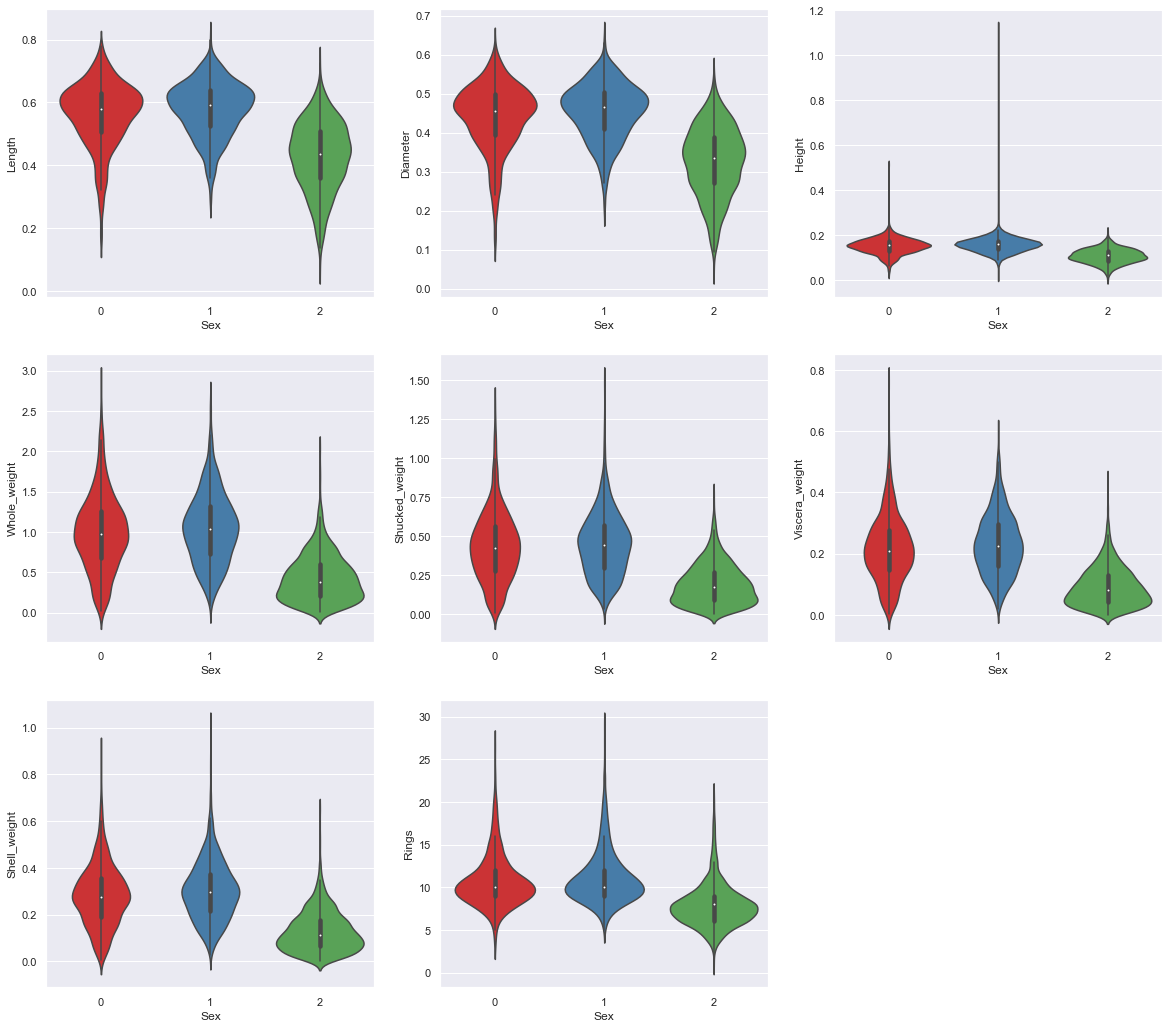

In [9]:
def violinos(d = dados):
    fig, ax = plt.subplots(3, 3, figsize = (20, 18))
    violinos = list(d.columns).copy()
    violinos.remove("Sex")

    c = 0
    for i in [0, 1, 2, 3]:
        for j in [0, 1, 2]:
            try:
                sns.violinplot(data = d, x = "Sex", y = violinos[c], ax = ax[i][j], palette = "Set1")
                c += 1
            except:
                pass
                   
    fig.delaxes(ax[2, 2])
    fig.show()

violinos()

### Pairplots

 No pairplot a presença dos outliers fica ainda mais clara. Perceba que algumas variáveis, como Height, tem pontos que estão fora da grande concentração ao redor das retas de regressão. Além disto algumas densidades(gráficos na diagonal) não apresentam aparentemente uma distribuição normal. Mas no geral grande parte dos dados está bem distribuido, com poucos outliers.

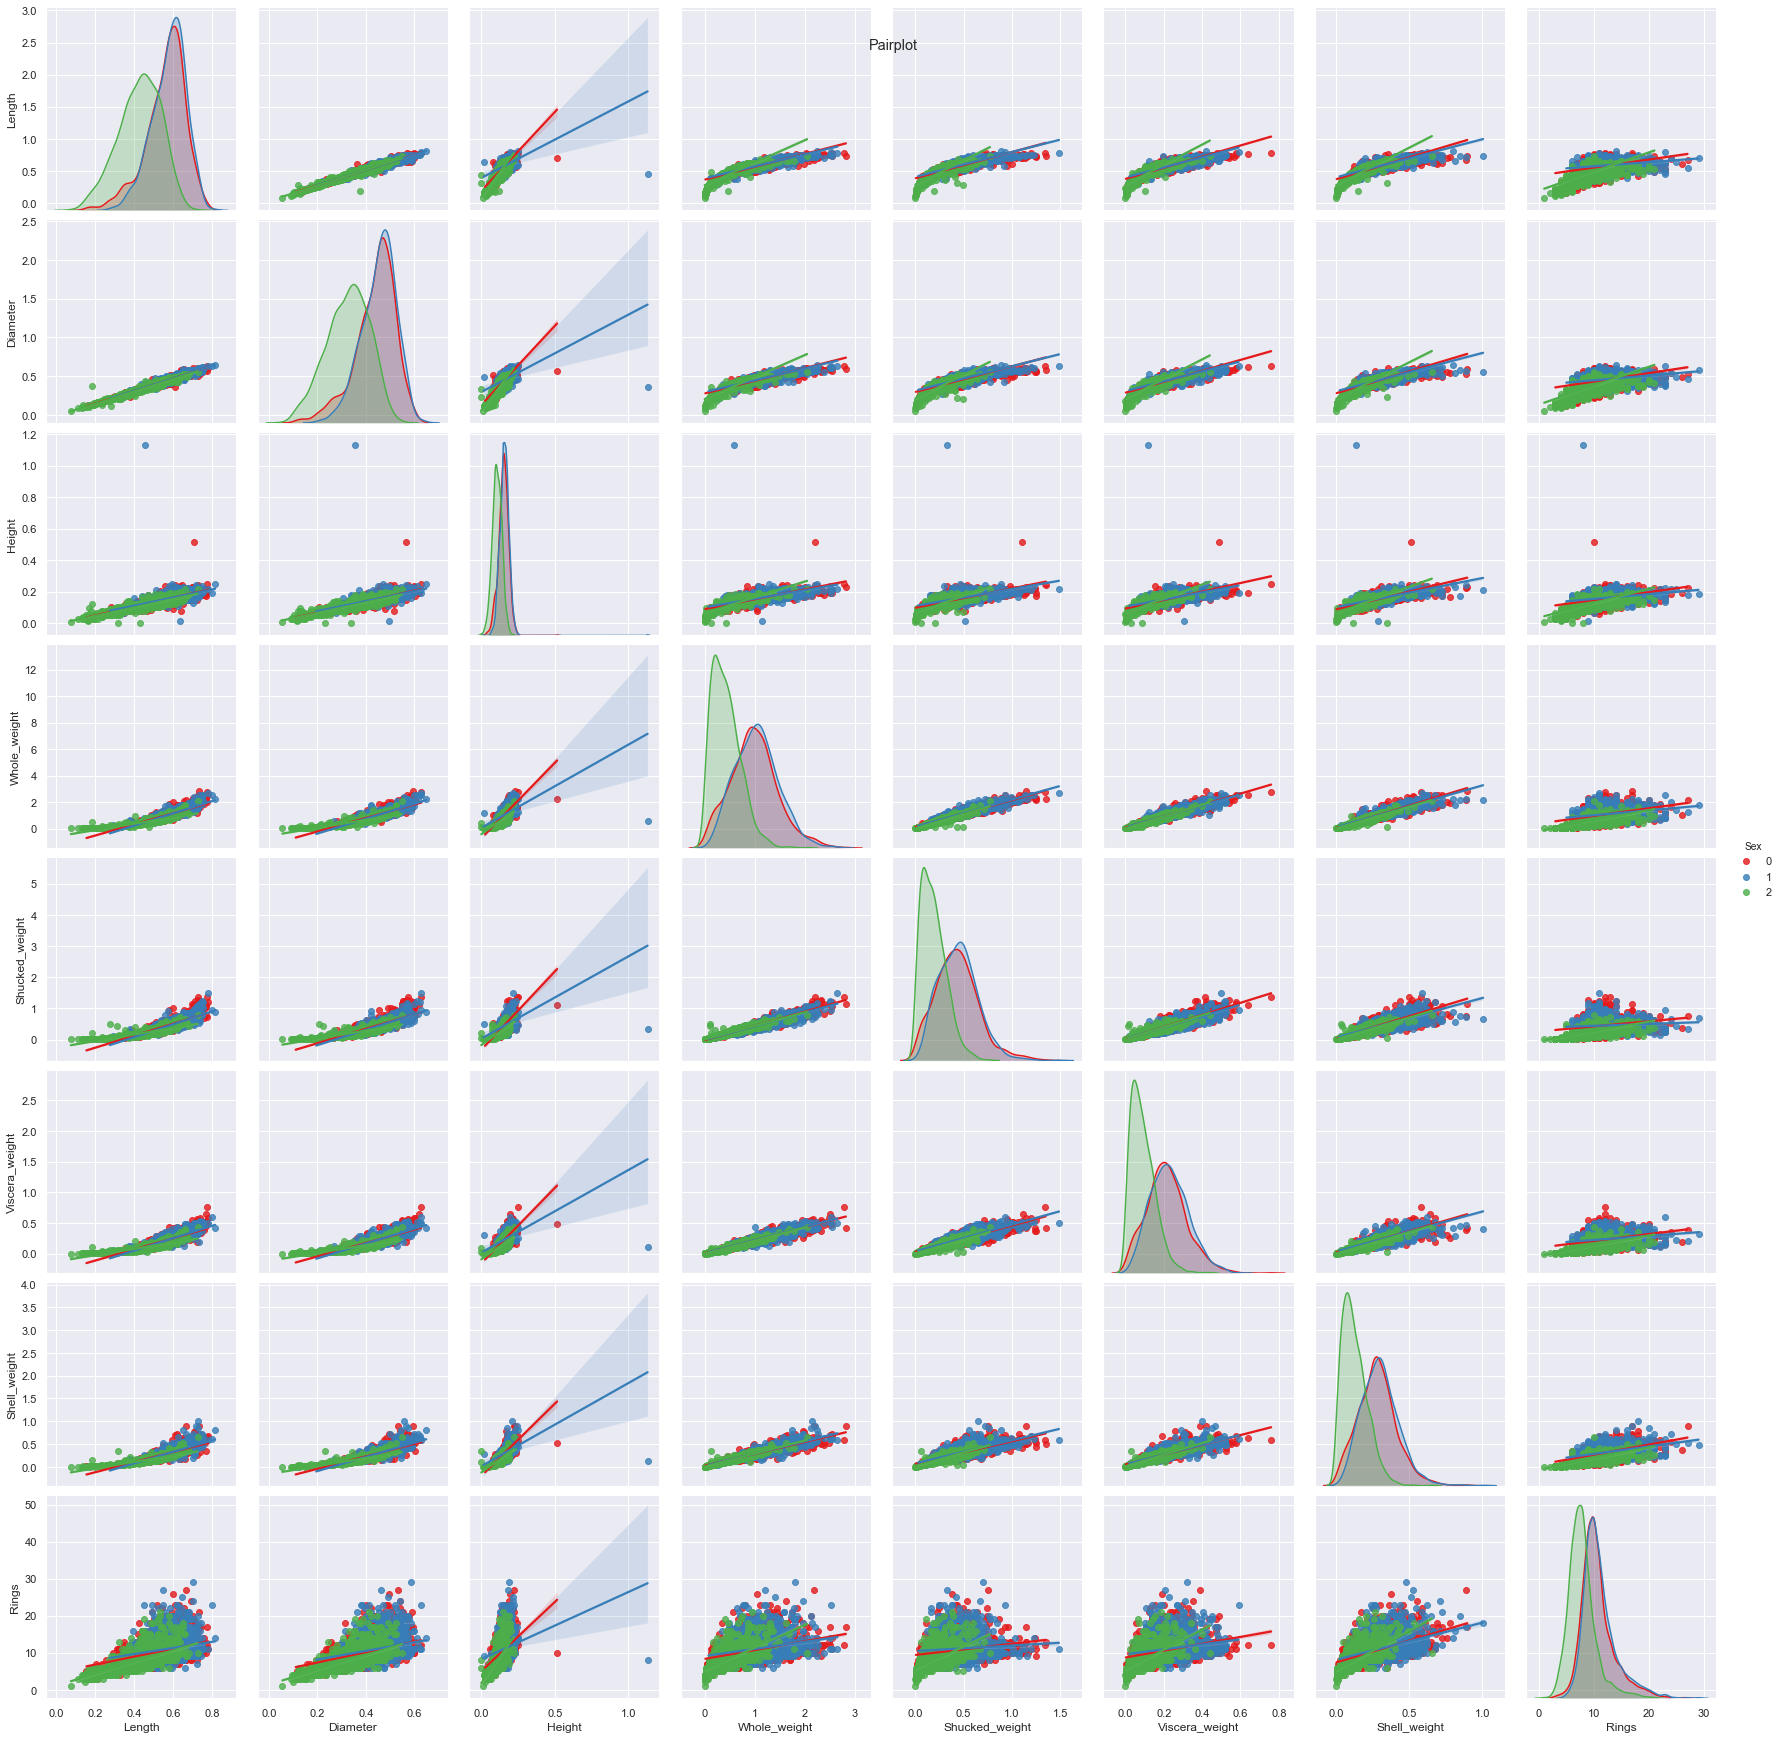

In [10]:
def pair(d = dados, titulo = "Pairplot", tamanho = 3):
    p = sns.pairplot(d, kind = "reg", hue = "Sex", diag_kind ="kde", palette = "Set1", size = tamanho)
    p.fig.suptitle(titulo)
    plt.show()

pair()

### Criando Novas Variáveis

 Como temos poucas variáveis e poucos dados(em relação a conjuntos de Big Data), temos a liberdade de criar variáveis que talvez possam ajudar o modelo a fazer previsões melhores. Mas não podemos cria-las de qualquer jeito, deve haver algum sentido em sua criação. E como neste projeto temos dados de peso e altura, a primeira variável que podemos pensar é no indice de massa corporal(IMC), que basicamente é o peso dividido pela altura ao quadrado. Podemos pensar também em manipular os comprimentos, somando-os ou multiplicando-os.
 
 Não existe garantia que estas variáveis nos ajudem, inclusive até podem atrapalhar, mas vale a pena tentarmos.

In [11]:
dados["Height_Length"] = dados.Height / (dados.Length ** 2)
dados["Whole_weight_Diameter"] = dados.Whole_weight / (dados.Diameter ** 2)
dados["Perimetro"] = (dados.Whole_weight_Diameter + dados.Height_Length) / 2
dados["Area"] = dados.Length * dados.Diameter

dados

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Height_Length,Whole_weight_Diameter,Perimetro,Area
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0.458882,3.858135,2.158508,0.166075
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0.734694,3.211107,1.972901,0.092750
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0.480598,3.837868,2.159233,0.222600
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0.645661,3.873147,2.259404,0.160600
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0.734619,3.152634,1.943626,0.084150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,0.516877,4.380247,2.448562,0.254250
4173,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0.387820,4.989669,2.688745,0.259600
4174,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0.569444,5.212188,2.890816,0.285000
4175,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0.384000,4.652992,2.518496,0.303125


### Correlações

 Vamos então falar das correlações entre as variáveis. E perceba que algumas talvez temos variáveis muito proximas uma das outras, que é o caso de Length e Diameter. Ambas mostram correlações com as outras variáveis de forma muito parecida. E isto também acontece com outras variáveis. Mas isto já era de se esperar pois estamos falando aqui de dados semelhantes sobre peso e altura.

 Por fim, perceba que a variável Sex, nós podemos transforma-la em outras três variáveis. Basicamente iremos criar colunas para cada sexo, onde seus valores serão 0 ou 1.
 
 Links:
 
 - https://stats.stackexchange.com/questions/168622/why-is-multicollinearity-not-checked-in-modern-statistics-machine-learning

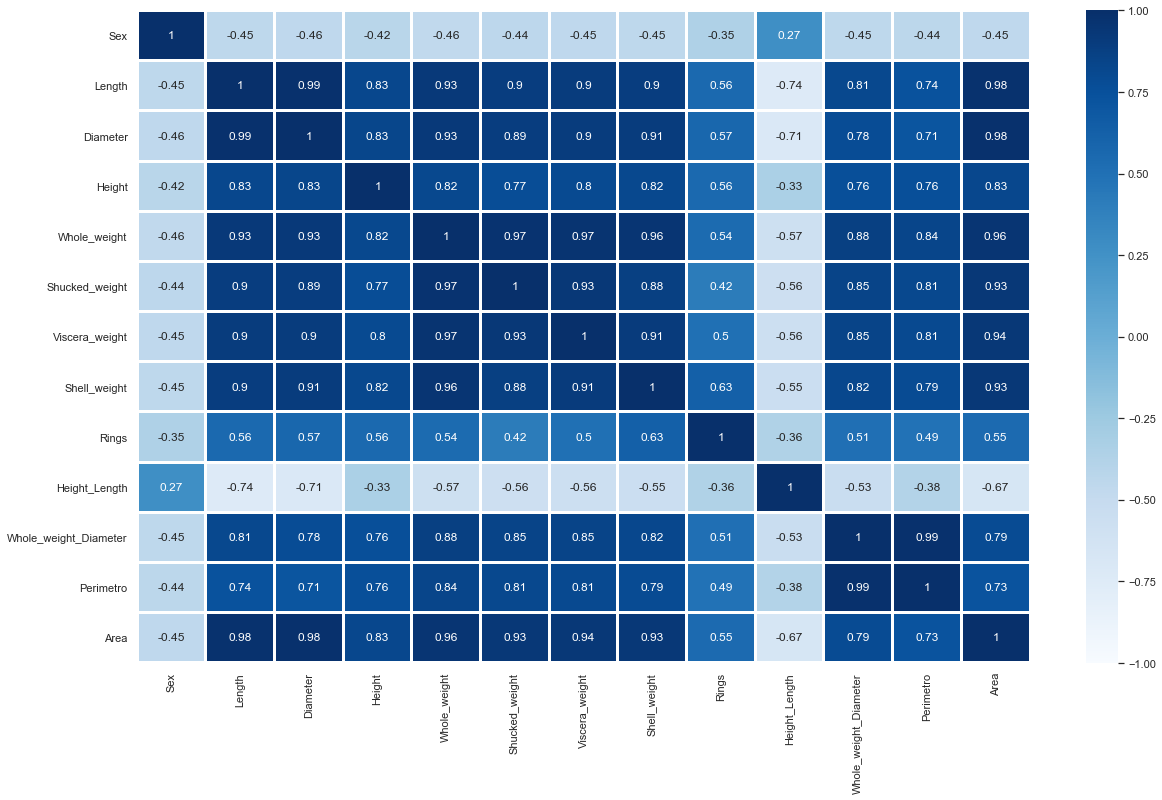

In [12]:
plt.figure(figsize=(20,12))
corr = dados.corr()
sns.heatmap(corr, center = 0, vmin = -1, vmax = 1, annot = True, linewidths = 2, cmap = "Blues")

dados.Sex = dados.Sex.astype(object)
dados_sex = dados.Sex
dados = pd.get_dummies(dados, drop_first = False)

### Pré-Processamento, Divisão dos Dados e Remoção de Outliers

 Vamos dividir nossos dados em treino e validação. Os dados de treino serão usados para treinar e testar o modelo, utilizando o cross-validation(em seguida) e por fim iremos realizar previsões nos dados de validação. E perceba que utilizaremos varias escalas diferentes nos dados, afim de encontrarmos aquela que torna nossas previsões melhores. E veja que algumas escalas não estão com valores default, diferentemente do primeiro projeto de diabetes onde estavamos utilizando parametros padrão no pré-processamento.

In [13]:
Nomes = list(dados.columns).copy()
Nomes.remove("Rings")

X = dados.copy()
X = X[Nomes]
Y = dados.copy()
Y = Y.Rings

X_A, X_val_A, Y, Y_val_A = train_test_split(X, Y, test_size = 0.1, random_state = 7)

escala_minmax = MinMaxScaler().fit(X_A)
X_B = escala_minmax.transform(X_A)

escala_minmax01 = MinMaxScaler(feature_range = (-1, 1)).fit(X_A)
X_B01 = escala_minmax01.transform(X_A)

escala_padronizada = StandardScaler().fit(X_A)
X_C = escala_padronizada.transform(X_A)

escala_robust = RobustScaler().fit(X_A)
X_D = escala_robust.transform(X_A)

escala_robust01 = RobustScaler(quantile_range = (10.0, 90.0)).fit(X_A)
X_D01 = escala_robust01.transform(X_A)

escala_maxabs = MaxAbsScaler().fit(X_A)
X_E = escala_maxabs.transform(X_A)

escala_normalizer = Normalizer().fit(X_A)
X_F = escala_normalizer.transform(X_A)

escala_normalizer01 = Normalizer(norm = "max").fit(X_A)
X_F01 = escala_normalizer01.transform(X_A)

escala_quantile = QuantileTransformer(random_state = 7).fit(X_A)
X_G = escala_quantile.transform(X_A)

escala_quantile01 = QuantileTransformer(random_state = 7, output_distribution = "normal").fit(X_A)
X_G01 = escala_quantile01.transform(X_A)

Y = Y.values

 Observe como a transformação por quartis(QuantileTransformer) trata os outliers e compare com o pairplot do inicio do projeto com a escala original dos dados. Os elementos estão muito mais distribuidos e existem poucos pontos que estão muito afastados da grande concentração dos dados.

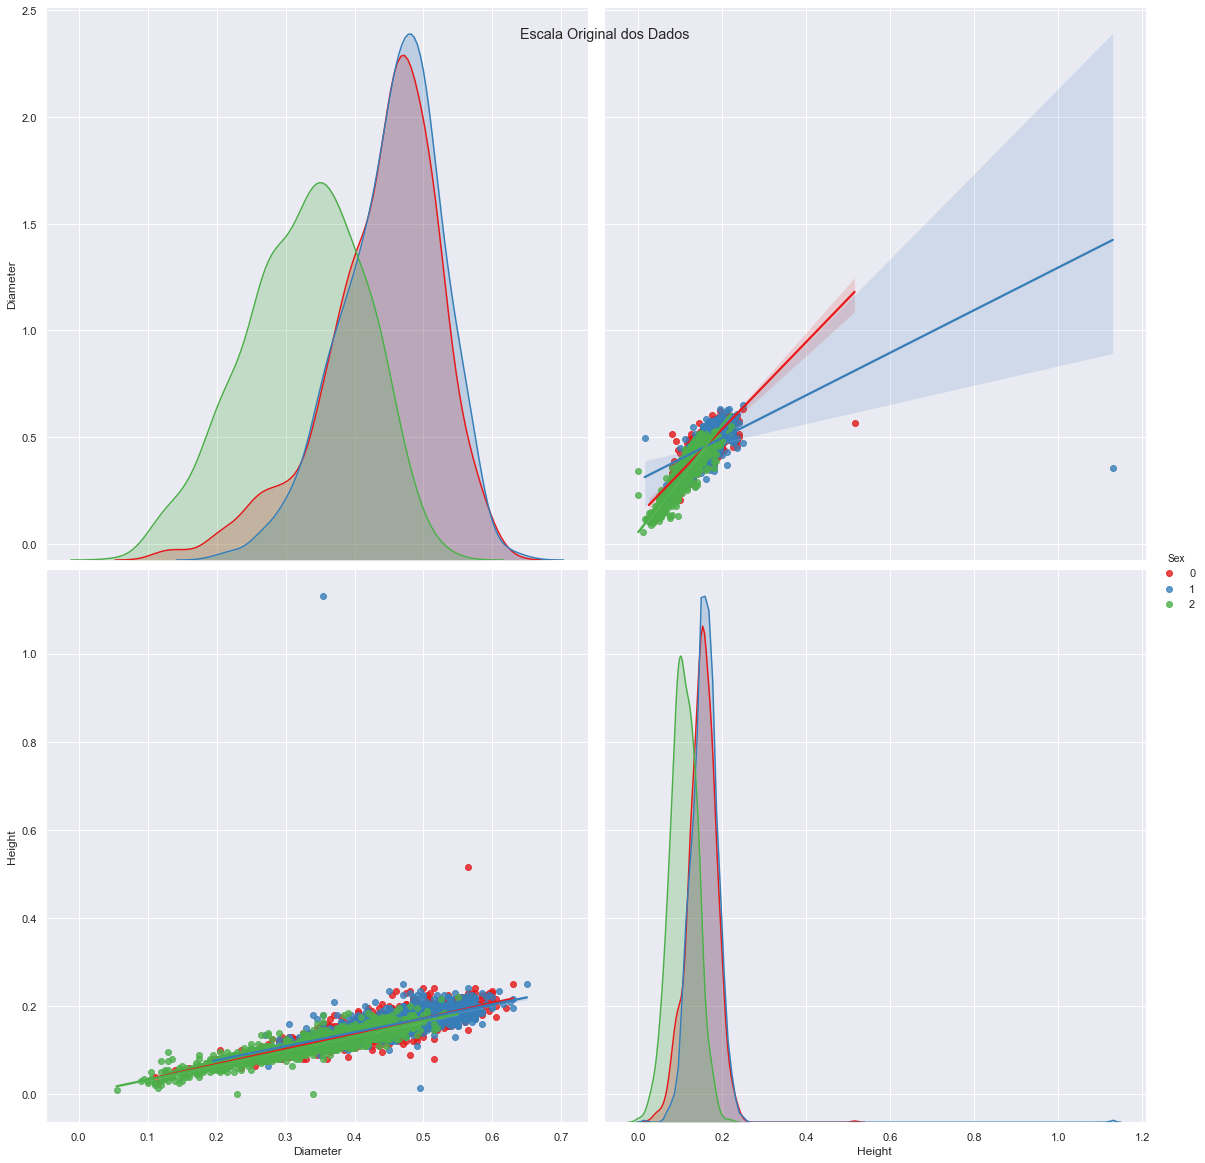

In [14]:
pair(pd.concat([dados[["Diameter", "Height"]], dados_sex], axis = 1), "Escala Original dos Dados", 8)

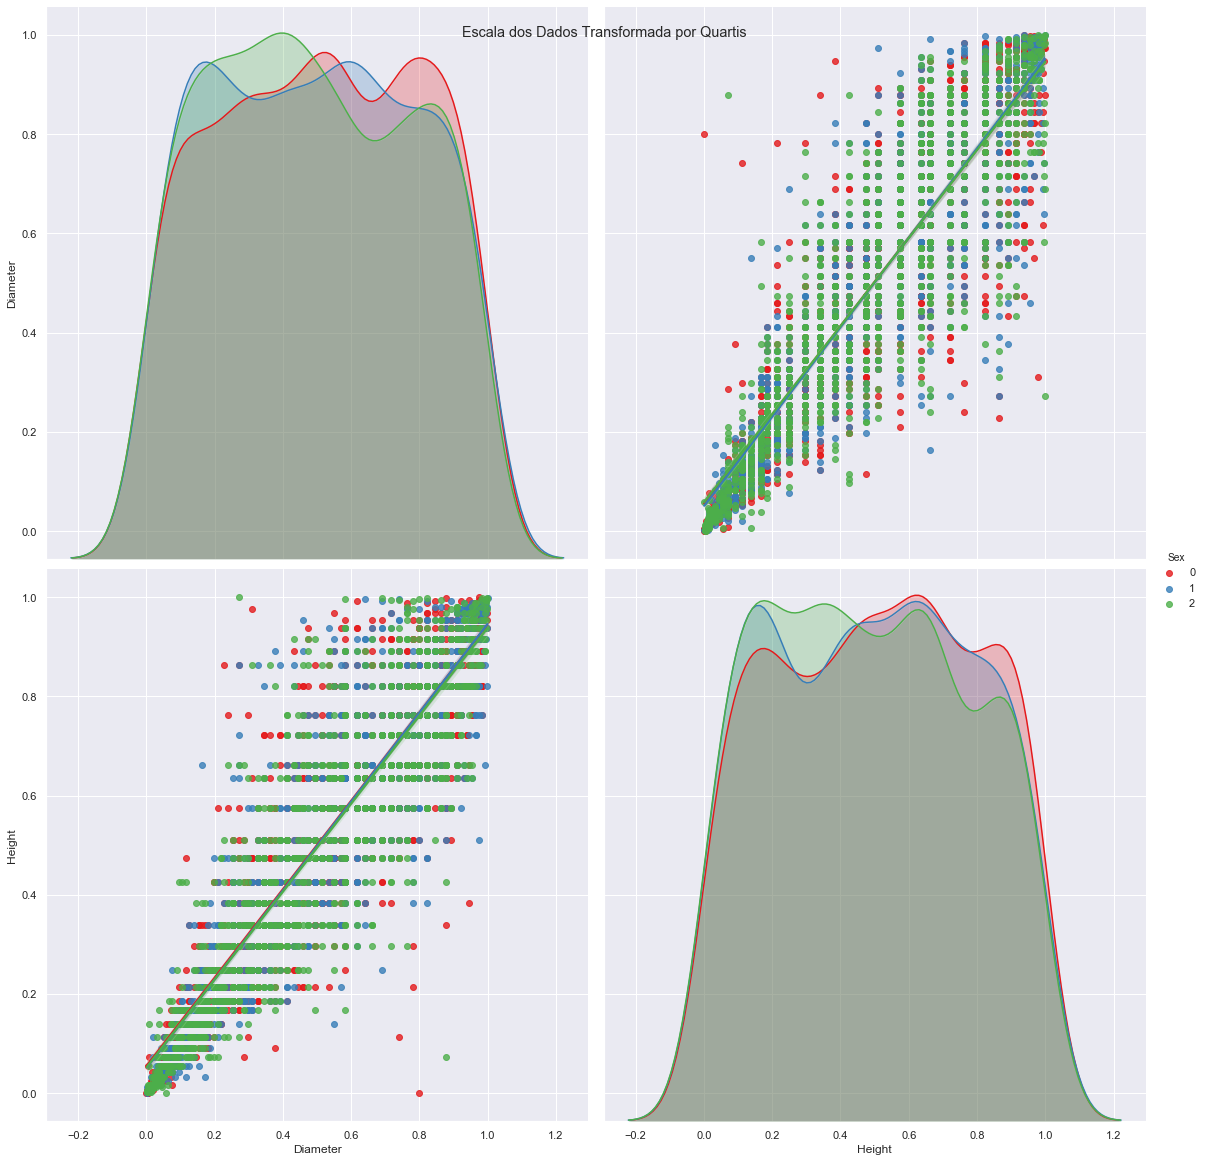

In [15]:
pair(pd.concat([pd.DataFrame(X_G[:,1:3], columns = ["Diameter", "Height"]), dados_sex], axis = 1), "Escala dos Dados Transformada por Quartis", 8)

### 1.0 - Cross Validation

 Afim de obtermos taxas de acertos mais fieis, livres do overfiting e underfiting, vamos aplicar a técnica de cross validation. Será utilizado basicamente o código do projeto anterior sobre diabetes, mas a diferença é que aqui o problema é de regressão e estamos utilizando mais escalas. Como métrica utilizaremos o erro médio quadratico(RMSE) e o r2. Além disto, o score da função SelectKBeste será o mutual_info_regression, exclusivo para problemas de regressão.

In [16]:
def cross_val(score_k, cv):
    escala = {"Original": [None, X_A.values],
              "MinMaxScaler": [preprocessing.MinMaxScaler(), X_B],
              "MinMaxScaler01": [preprocessing.MinMaxScaler(feature_range = (-1, 1)), X_B01],
              "StandardScaler": [preprocessing.StandardScaler(), X_C],
              "RobustScaler": [preprocessing.RobustScaler(), X_D],
              "RobustScaler01": [preprocessing.RobustScaler(quantile_range = (10.0, 90.0)), X_D01],
              "MaxAbsScaler": [preprocessing.MaxAbsScaler(), X_E],
              "Normalizer": [preprocessing.Normalizer(), X_F],
              "QuantileTransformer": [preprocessing.QuantileTransformer(random_state = 7), X_G],
              "QuantileTransformer01": [preprocessing.QuantileTransformer(random_state = 7, output_distribution = "normal"), X_G01]}
    
    metricas = {"RMSE": "neg_root_mean_squared_error",
                "r2": "r2"}
    
    modelo = CatBoostRegressor(random_state = 7,
                               verbose = False,
                               boosting_type = "Plain",
                               bootstrap_type = "Bernoulli",
                               iterations = 700)
    
    c = 0
    resultados = []
    for esc in escala:
        for K in [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]:
            
            kbest = SelectKBest(score_k, k = K).fit(escala[esc][1], Y)
            colunas = kbest.get_support(indices = True)
            cross = cross_validate(make_pipeline(escala[esc][0], modelo), X_A.values[:,colunas], Y, cv = cv, scoring = metricas)

            resultados.append(("CatBoostRegressor", esc, K, (sum(cross["test_RMSE"]) / cv.n_splits), (sum(cross["test_r2"]) / cv.n_splits)))
            if c % 11 == 0:
                print(resultados[c])
            c += 1
            
    return pd.DataFrame(resultados, columns = ["Modelos", "Escala dos Dados", "Variáveis Utilizadas",
                                               "RMSE Médio", "R2 Médio"]).sort_values("RMSE Médio", ascending = False)

#results = cross_val(mutual_info_regression, StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7))
#results.to_csv(r"abalone_cross0.csv", index = False)
results = pd.read_csv("abalone_cross0.csv")
results.head(56)

,Modelos,Escala dos Dados,Variáveis Utilizadas,RMSE Médio,R2 Médio
0,CatBoostRegressor,Normalizer,6,-2.120303,0.561399
1,CatBoostRegressor,Normalizer,9,-2.139214,0.553297
2,CatBoostRegressor,Normalizer,11,-2.140398,0.552799
3,CatBoostRegressor,Normalizer,10,-2.140562,0.552760
4,CatBoostRegressor,Normalizer,13,-2.140943,0.552538
5,CatBoostRegressor,Normalizer,14,-2.144256,0.551369
6,CatBoostRegressor,Original,12,-2.145962,0.550664
7,CatBoostRegressor,MaxAbsScaler,12,-2.146059,0.550624
8,CatBoostRegressor,RobustScaler01,12,-2.146114,0.550601
9,CatBoostRegressor,RobustScaler,12,-2.146379,0.550488


In [17]:
def cross_variaveis(r = results):
    R = r[r["RMSE Médio"] == r["RMSE Médio"].max()].values[0]
    
    escala = {"Original": [None, X_A],
              "MinMaxScaler": [preprocessing.MinMaxScaler(feature_range = (0, 1)), X_B],
              "StandardScaler": [preprocessing.StandardScaler(), X_C],
              "RobustScaler": [preprocessing.RobustScaler(), X_D],
              "MaxAbsScaler": [preprocessing.MaxAbsScaler(), X_E],
              "Normalizer": [preprocessing.Normalizer(), X_F],
              "QuantileTransformer": [preprocessing.QuantileTransformer(), X_G]}
    
    kb = SelectKBest(mutual_info_regression, k = R[2]).fit(escala[R[1]][1], Y)
    colunas = kb.get_support(indices = True)
    kb = pd.DataFrame(escala[R[1]][1]).iloc[:,colunas]
    
    print("Quantidade de Variáveis Mais Importantes: ", R[2])
    print("Escala dos Dados: ", R[1])
    print("Variáveis Utilizadas:")
    for i in colunas:
        print(Nomes[i])
        
    return kb, colunas

X, colunas = cross_variaveis(results)
X.dtypes
X.head(7)

Quantidade de Variáveis Mais Importantes:  6
Escala dos Dados:  Normalizer
Variáveis Utilizadas:
Whole_weight
Shucked_weight
Viscera_weight
Shell_weight
Height_Length
Area


,3,4,5,6,7,10
0,0.089200,0.046243,0.018544,0.021126,0.133373,0.034084
1,0.215587,0.098449,0.048509,0.062028,0.067054,0.051507
2,0.100946,0.039967,0.021446,0.031410,0.127483,0.035634
3,0.083619,0.038171,0.015064,0.025533,0.125289,0.035950
4,0.154068,0.076939,0.030927,0.042027,0.083158,0.045281
5,0.099384,0.040791,0.021972,0.033772,0.105914,0.032989
6,0.196124,0.078041,0.032165,0.075124,0.082325,0.043156


 A partir dos resultados obtidos do cross validation, precisamos agora utilizar as variáveis que tornaram a previsão dos resultados melhores.

In [18]:
def previsao(r, g1, g2, c):
    R = r[r["RMSE Médio"] == r["RMSE Médio"].max()].values[0]
    
    if R[1] == "MinMaxScaler":
        X_ = escala_minmax.transform(g1)
    
    elif R[1] == "Original":
        X_ = g1
    
    elif R[1] == "StandardScaler":
        X_ = escala_padronizada.transform(g1)
    
    elif R[1] == "RobustScaler":
        X_ = escala_robust.transform(g1)
    
    elif R[1] == "Normalizer":
        X_ = escala_normalizer.transform(g1)
    
    elif R[1] == "MaxAbsScaler":
        X_ = escala_maxabs.transform(g1)
    
    else:
        X_ = escala_quantile.transform(g1)
    
    return pd.DataFrame(X_).iloc[:,c], g2

X_val, Y_val = previsao(results, X_val_A, Y_val_A, colunas)
val = X_val.head(7)
X_val = X_val.values
val

,3,4,5,6,7,10
0,0.184879,0.095933,0.035720,0.045847,0.070778,0.044646
1,0.150716,0.074497,0.031992,0.039242,0.089880,0.042369
2,0.098808,0.050533,0.019031,0.024944,0.111785,0.034126
3,0.190745,0.079735,0.047910,0.042548,0.053688,0.042445
4,0.180414,0.075074,0.037375,0.051701,0.091217,0.058217
5,0.117414,0.061298,0.024220,0.028008,0.097628,0.037003
6,0.025579,0.008788,0.005022,0.009729,0.337867,0.015206


### Otimização

 Como o CatBoostRegressor e CatBoostClassifier tem os mesmos hiperparâmetros, o processo de otimização será o mesmo que o problema de diabetes, com a simples dirença de estarmos utilizando o CatBoostRegressor. Além disto, a métrica que escolhemos para minimizar será o RMSE, ou seja, queremos diminuir os erros nas nossas previsões.
 
 Vale ressaltar que como este problema contém mais dados, o tempo de execução será maior.
 
 Links:
 
 - https://www.youtube.com/watch?v=WhnkeasZNHI&t

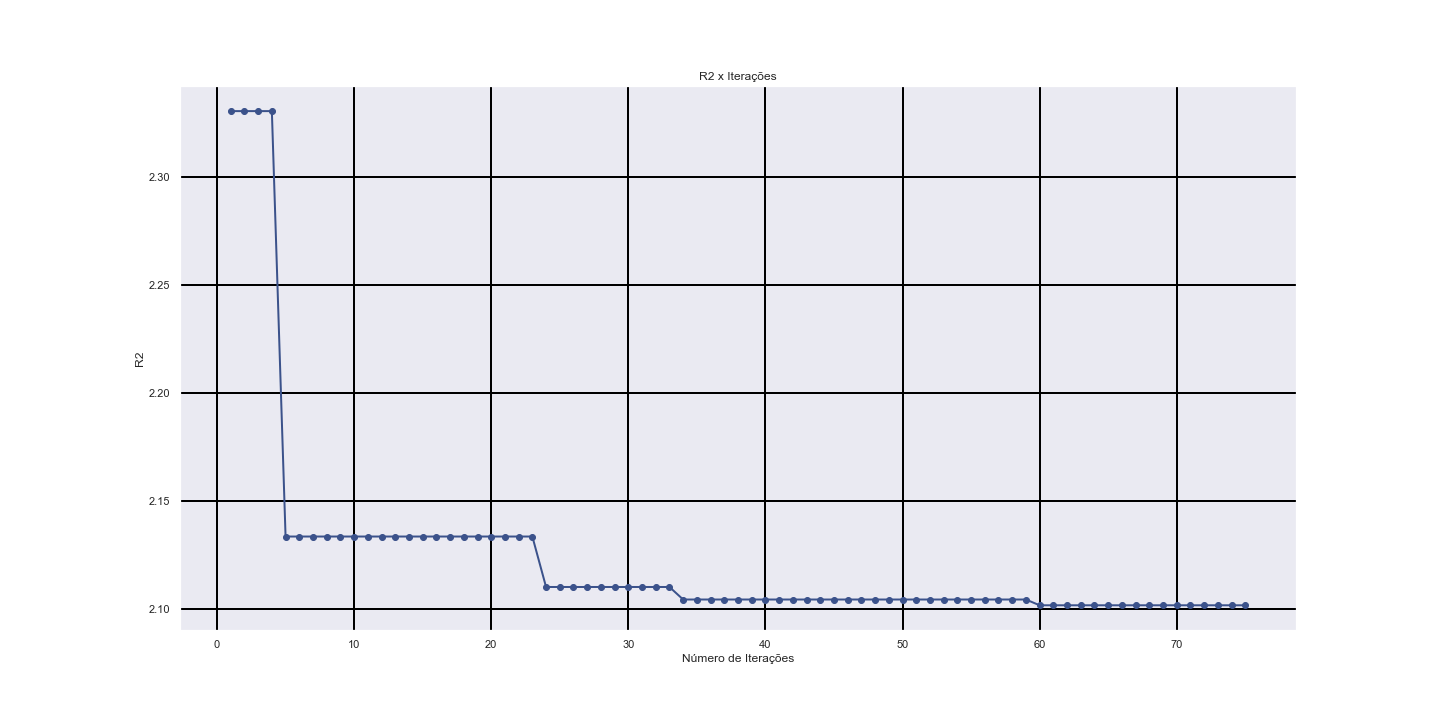

In [19]:
def minimizar_catr(params, r = results):
    learning_rate = params[0]
    l2_leaf_reg = params[1]
    depth = params[2]
    iterations = params[3]
    od_type = params[4]
    random_strength = params[5]
    od_wait = params[6]
    
    #print(params)
    
    modelo = CatBoostRegressor(random_state = 7,
                                verbose = False,
                                learning_rate = learning_rate,
                                l2_leaf_reg = l2_leaf_reg,
                                depth = depth,
                                iterations = iterations,
                                od_type = od_type,
                                random_strength = random_strength,
                                od_wait = od_wait,
                                boosting_type = "Plain",
                                bootstrap_type = "Bernoulli")
    
    R = r[r["RMSE Médio"] == r["RMSE Médio"].max()].values[0]
    
    escala = {"Original": None,
              "MinMaxScaler": preprocessing.MinMaxScaler(),
              "StandardScaler": preprocessing.StandardScaler(),
              "RobustScaler": preprocessing.RobustScaler(),
              "MaxAbsScaler": preprocessing.MaxAbsScaler(),
              "Normalizer": preprocessing.Normalizer()}
    
    metricas = {"neg": "neg_root_mean_squared_error"}
    
    resultados = cross_validate(make_pipeline(escala[R[1]], modelo), X, Y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7), scoring = metricas)
    
    return - sum(resultados["test_neg"]) / 5

espaco = [(0.0001, 1.0),
          (1, 9),
          (4, 10),
          (800, 1200),
          ("IncToDec", "Iter"),
          (0.01, 10.0),
          (10, 30)]

#resultados_otimizacao = gp_minimize(minimizar_catr, espaco, random_state = 1, n_calls = 75, n_random_starts = 10, verbose = False)

def iteracoes():
    figure(figsize = (20,10))
    resultados_otimizacao.func_vals[0] = resultados_otimizacao.func_vals[1]
    plot_convergence(resultados_otimizacao)
    plt.title("R2 x Iterações")
    plt.xlabel("Número de Iterações")
    plt.ylabel("R2")
    plt.grid(color = 'black', linestyle = '-', linewidth = 2)
    plt.savefig('imagem_catr.png')
    plt.show()

#iteracoes()
    
display(Image(filename='imagem_catr.png')) 

## Previsões

 Modelo treinado e otimizado, basta então realizarmos nossas previsões. E iremos realiza-las nos dados de validação, nos dados de treino e em todos os dados disponíveis desde a extração de dados(e sem valores missing).

### Dados de Validação

________________________________________________________________MODELO OTIMIZADO APLICADO NOS DADOS DE VALIDAÇÃO:
________________________________________________________________RMSE:  2.253121173821649
________________________________________________________________PEARSON:  0.7582566220115708
________________________________________________________________DISTRIBUIÇÃO POLIGONAL:  1.34E+02
________________________________________________________________R2:  0.5626123060840065
________________________________________________________________ERRO RESIDUAL MÁXIMO:  9.0
________________________________________________________________MAE:  1.4976076555023923


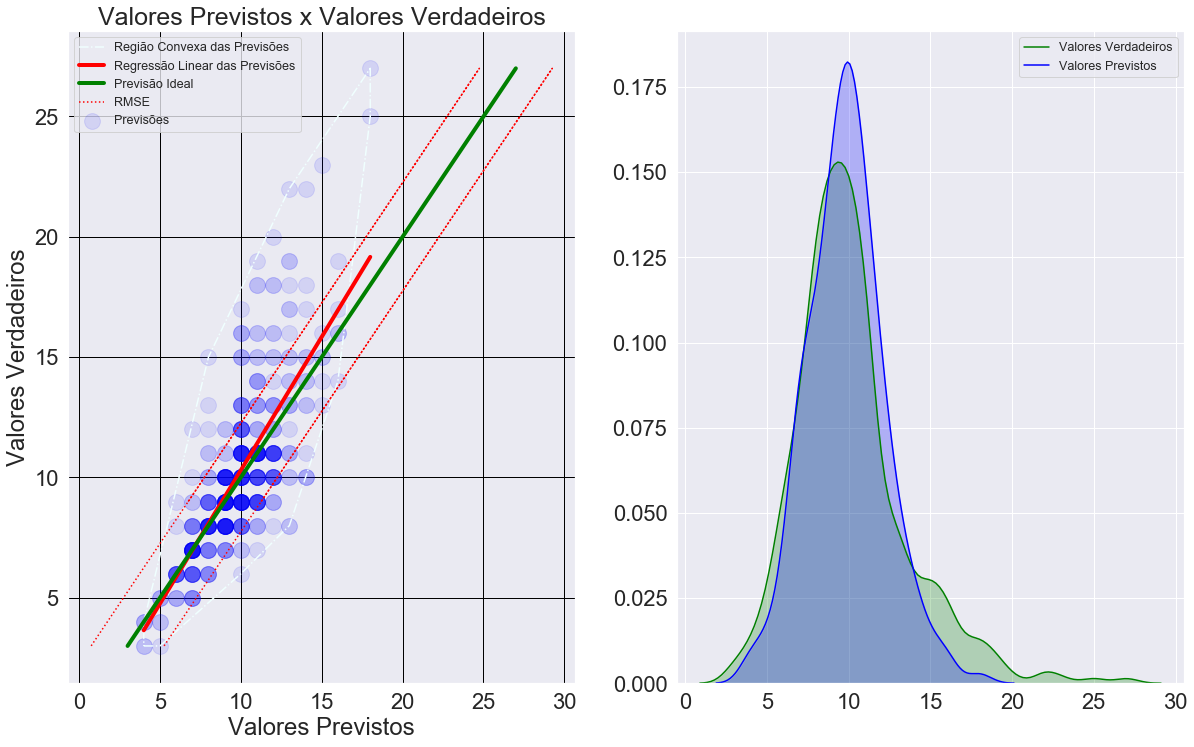

In [20]:
def convexhull(p):
    p = np.array(p)
    hull = ConvexHull(p)
    return p[hull.vertices,:]

def modelos(modelo, Xtreino, Ytreino, Xteste, Yteste):
    sns.set(font_scale = 2)
    modelo.fit(Xtreino, Ytreino)
    
    valores_previstos = modelo.predict(Xteste)
    valores_previstos = np.abs(np.rint(valores_previstos))
        
    modelo1 = LinearRegression()
    modelo1 = modelo1.fit(pd.DataFrame(valores_previstos), Yteste)
    reta = modelo1.intercept_ + modelo1.coef_ * valores_previstos
    reta1 = Yteste
    
    min_reta = modelo1.intercept_ + modelo1.coef_ * min(valores_previstos)
    max_reta = modelo1.intercept_ + modelo1.coef_ * max(valores_previstos)
    
    RMSE = mean_squared_error(Yteste, valores_previstos, squared = False)
    r2 = r2_score(Yteste, valores_previstos)
    resid = max_error(Yteste, valores_previstos)
    mae = mean_absolute_error(Yteste, valores_previstos)
    
    produto_cartesiano = []
    for i in range(len(Yteste)):
        produto_cartesiano.append((valores_previstos[i], Yteste.reset_index(drop = True)[i]))  
    
    poly = Polygon(convexhull(produto_cartesiano))
    x,y = poly.exterior.xy
    
    print("________________________________________________________________RMSE: ", RMSE)
    print("________________________________________________________________PEARSON: ", pearsonr(reta1, reta)[0])
    print("________________________________________________________________DISTRIBUIÇÃO POLIGONAL: ", '%.2E' % Decimal(str(poly.area)))
    print("________________________________________________________________R2: ", r2)
    print("________________________________________________________________ERRO RESIDUAL MÁXIMO: ", resid)
    print("________________________________________________________________MAE: ", mae)
    
    fig, ax = plt.subplots(1, 2, figsize = (20,12))
    ax[0].plot(x, y, linestyle = "-.", color = "azure", label = "Região Convexa das Previsões")
    sns.lineplot(valores_previstos, reta, color = "red", ax = ax[0], label = "Regressão Linear das Previsões", linewidth = 4)
    sns.lineplot(reta1, reta1, color = "green", ax = ax[0], label = "Previsão Ideal", linewidth = 4)
    ax[0].plot(reta1 + RMSE, reta1, color = "red", linestyle = ":", label = "RMSE")
    ax[0].plot(reta1 - RMSE, reta1, color = "red", linestyle = ":")
    ax[0].grid(color = 'black', linestyle = '-', linewidth = 1.0)
    ax[0].scatter(x = valores_previstos, y = Yteste,  color = "blue", s = 250, alpha = 0.1, label = "Previsões")
    ax[0].set_title("Valores Previstos x Valores Verdadeiros", fontsize = 25)
    ax[0].set_xlabel("Valores Previstos")
    ax[0].set_ylabel("Valores Verdadeiros")
    ax[0].legend(fontsize = 12.5)
    
    sns.kdeplot(Yteste, color = "green", ax = ax[1], shade = True, label = "Valores Verdadeiros")
    sns.kdeplot(valores_previstos, color = "blue", ax = ax[1], shade = True, label = "Valores Previstos")
    ax[1].legend(fontsize = 12.5)
    
    plt.show()

arquivo = "modelo_catc.sav"
'''
pickle.dump(CatBoostRegressor(random_state = 7,
                                verbose = False,
                                learning_rate = resultados_otimizacao.x[0],
                                l2_leaf_reg = resultados_otimizacao.x[1],
                                depth = resultados_otimizacao.x[2],
                                iterations = resultados_otimizacao.x[3],
                                od_type = resultados_otimizacao.x[4],
                                random_strength = resultados_otimizacao.x[5],
                                od_wait = resultados_otimizacao.x[6],
                                boosting_type = "Plain",
                                bootstrap_type = "Bernoulli"), open(arquivo, 'wb'))
'''
modelo_otimizado = pickle.load(open(arquivo, 'rb'))

print("________________________________________________________________MODELO OTIMIZADO APLICADO NOS DADOS DE VALIDAÇÃO:")
modelos(modelo_otimizado, X, Y, X_val, Y_val)

### Dados de Treino

 Perceba que a previsão dos dados de treino foram um pouco diferentes dos dados de validação.

________________________________________________________________RMSE:  1.7825377439834829
________________________________________________________________PEARSON:  0.8337286312149016
________________________________________________________________DISTRIBUIÇÃO POLIGONAL:  2.02E+02
________________________________________________________________R2:  0.6901059488150164
________________________________________________________________ERRO RESIDUAL MÁXIMO:  10.0
________________________________________________________________MAE:  1.2561851556264965


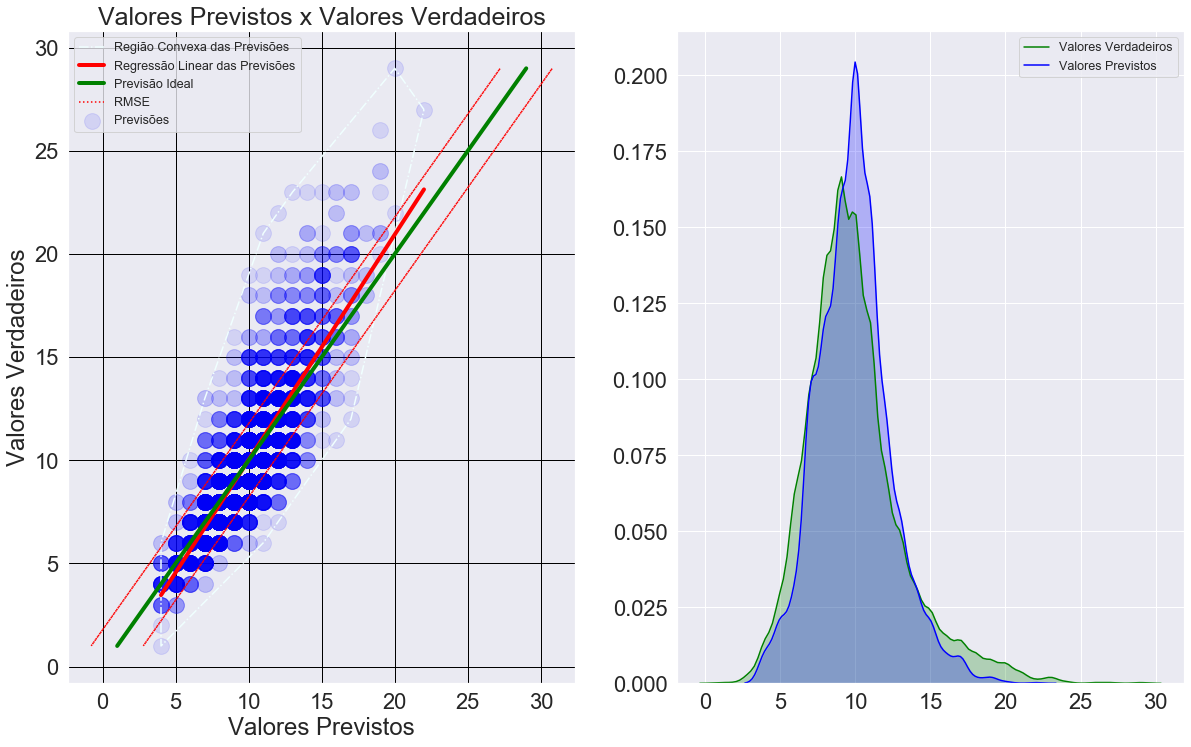

In [21]:
modelos(modelo_otimizado, X, Y, X, pd.Series(Y))

### Todos os Dados

 Por fim, faremos previsões em todos os dados originais. E veja que obtemos um resultado similar e satisfatório em relação as previsões nos dados de treino.

________________________________________________________________RMSE:  1.8350718318916182
________________________________________________________________PEARSON:  0.8252978276934468
________________________________________________________________DISTRIBUIÇÃO POLIGONAL:  2.02E+02
________________________________________________________________R2:  0.6759779849579822
________________________________________________________________ERRO RESIDUAL MÁXIMO:  10.0
________________________________________________________________MAE:  1.2803447450323198


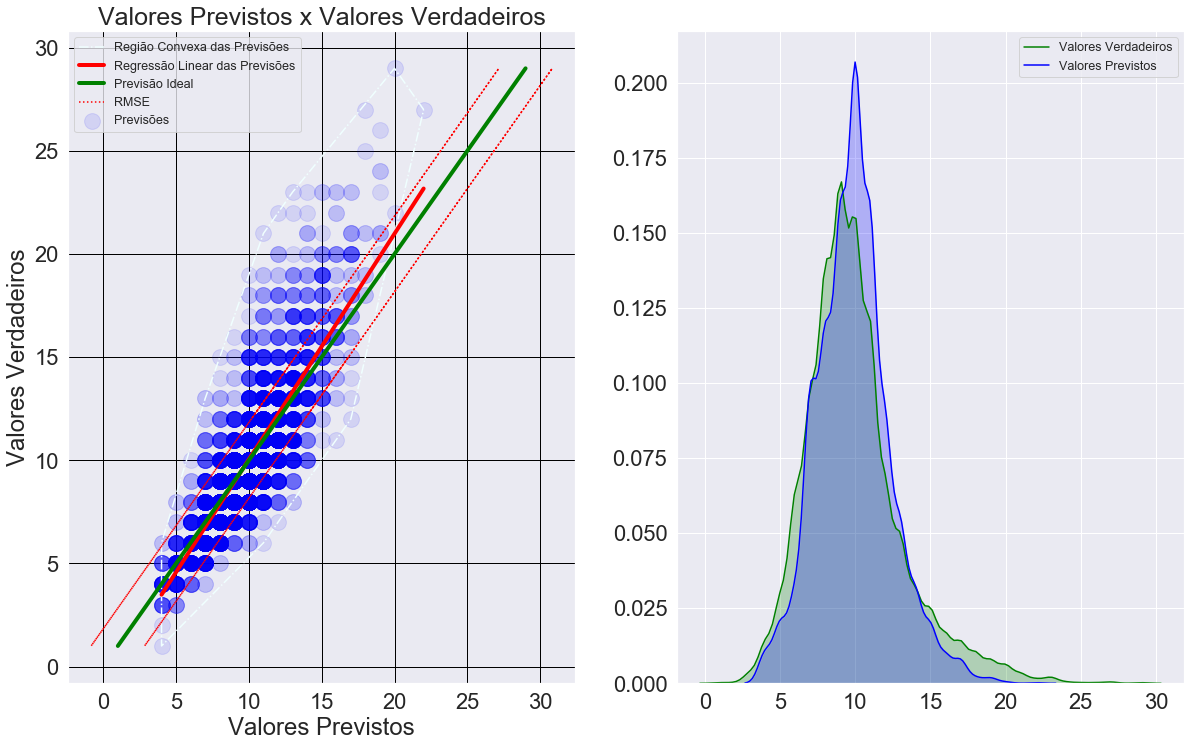

In [22]:
x0, y = previsao(r = results, g1 = dados.loc[:,dados.columns != "Rings"], g2 = dados.Rings, c = colunas)

modelos(modelo_otimizado, X, Y, x0, y)